# Feature Selection

For large datasets, feature selection, where we try to choose the best features to fit our models to, is an important preprocessing step. The benefits of this are reducing data storage requirements, reducing calculation times for fitting, and improving the robustness of the model. We have previously investigated embedded methods such as Lasso or Ridge regularization for linear and logistic regression and SVM models which implicitly do this. Here we will investigate some basic techniques using the scikit-learn library which enable us to undertake feature selection. These methods fall into the categories of filter and wrapper methods. For filter methods the filtering is done as a preprocessing step and is independent of the final model we create. Whereas for wrapper methods we require a machine learning algorithm and use the metrics of that model to guide the feature selection.

To investigate these basic feature selection methods we will use the Wisconsin Breast Cancer dataset which you will need to download from [Monash Gitlab](https://gitlab.erc.monash.edu.au/bads/data-challenges-resources/-/blob/main/Machine-Learning/Supervised-Methods/kaggle-wisconsin-cancer.csv) or [Kaggle](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data). This datasets records 30 physical features of digitized images of cells, and classifies them as benign (B) or malignant (M).



## Contents

* Inputs
* Multicollinearity
* Variance threshold
* SelectKBest
* Select from model
* Recursive feature elimination
* Sequential feature selection

## Inputs

We first import the standard libraries.

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

Read in the csv file to a pandas dataframe and show the descriptive statistics.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
df = pd.read_csv('/content/drive/MyDrive/csv files/kaggle-wisconsin-cancer.csv') # read the dataset in to a pandas dataframe
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


The diagnosis corresponds to M (malignant) or B (benign), with 37% M. For this problem we want to minimize false negatives, i.e., predictions that the tumour is benign, when it is actually malignant. Hence we want to maximize the recall = TP/(TP+FN).

We create a dataframe of the features, and undertake some minimal cleaning. Then we convert the diagnosis from categories to a binary classification where 1 represents M and 0 represents B.

In [8]:
features = df.drop(["id", "diagnosis"], axis=1)
labels = df["diagnosis"].astype('category').cat.codes

## Multicollinearity

The first filtering method we should undertake is to remove features which have very high absolute correlation to reduce the problem of collinearity. We can determine whether this is required by displaying the maximum and minimum values of the correlation matrix for the features. This demonstrates that some features have high positive correlation, but high negative correlation is not a problem.

In [9]:
corrs = features.corr() # calculate the correlation table
upper_tri = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(np.bool))
print('Minimum correlation is',np.round(upper_tri.min().min(),3))
print('Maximum correlation is',np.round(upper_tri.max().max(),3))

Minimum correlation is -0.312
Maximum correlation is 0.998


<ipython-input-9-b63b3764e9d5>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(np.bool))


To get an idea of the correlated features we can display the correlation matrix. The features that are highly correlated in this case are the biege entries, which corresponds to approximately 7 features.

<ipython-input-10-e96573c0c91b>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corrs, dtype=np.bool))


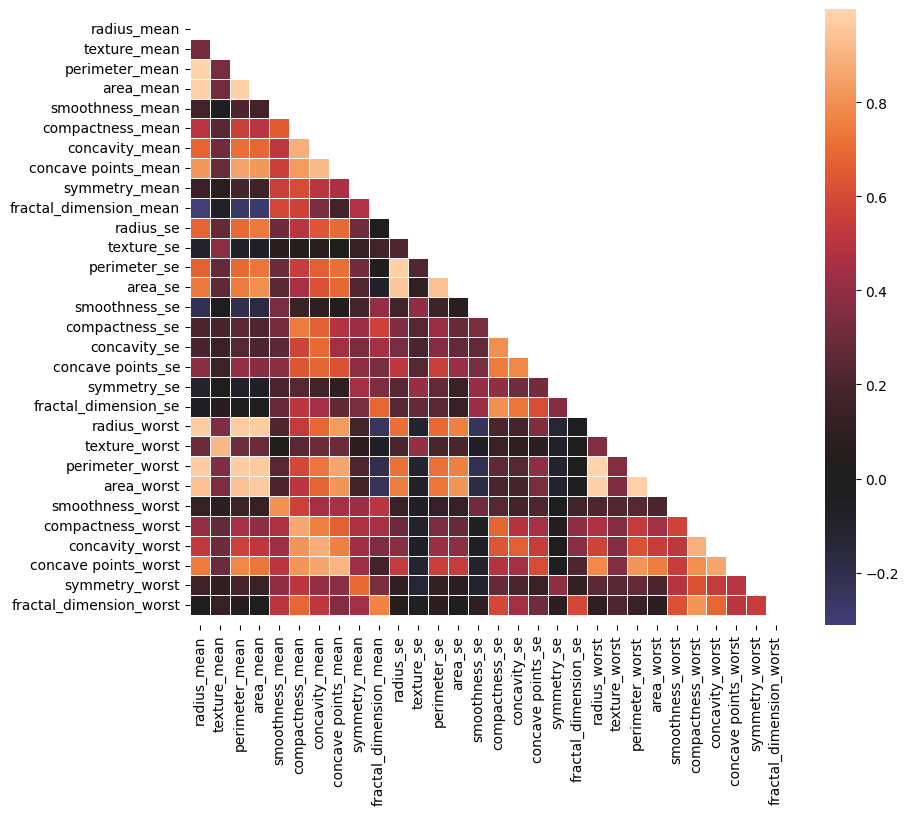

In [10]:
# as this is a symmetric table, set up a mask so that we only plot values below the main diagonal
mask = np.triu(np.ones_like(corrs, dtype=np.bool))
f, ax = plt.subplots(figsize=(10, 8)) # initialise the plots and axes
# plot the correlations as a seaborn heatmap, with a colourbar
sns.heatmap(corrs, mask=mask, center=0, annot=False, square=True, linewidths=.5)
# do some fiddling so that the top and bottom are not obscured
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

We can then iterate through the columns of the matrix and drop any columns which have an absolute correlation greater than some critical value. Those columns can be displayed and then dropped from the features.

In [11]:
upper_tri = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(np.abs(upper_tri[column]) > 0.95)]
print(to_drop)
tfeatures = features.drop(features[to_drop], axis=1)

['perimeter_mean', 'area_mean', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst']


<ipython-input-11-43e5c704b449>:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = corrs.where(np.triu(np.ones(corrs.shape),k=1).astype(np.bool))


As a check, we should compare the model accuracy with the full feature set and the reduced feature set. To do this we introduce a function which fits an sklearn model and calculates the accuracy, precision and recall. This uses the sklearn `StandardScalar` as a pipeline to first normalize the features.

In [12]:
def model_accuracy(model, features, labels, randomnumb=42):
    '''Convenience function to fit an sklearn model and calculate the accuracy, precision and recall'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import accuracy_score, precision_score, recall_score # import the score functions
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=randomnumb)
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)  # apply scaling on training data
    y_pred= pipe.predict(X_test) # calculate the predicted values of the model for the test features

    accuracy = np.round(accuracy_score(y_test, y_pred),3)
    precision = np.round(precision_score(y_test, y_pred),3)
    recall = np.round(recall_score(y_test, y_pred),3)

    print('Metrics for', model)
    print('Accuracy ', accuracy)
    print('Precision ', precision)
    print('Recall ', recall)
    print('\n')

    return (accuracy, precision, recall)

We can then use a simple logistic regression model to compare the results for the full dataset and the trimmed dataset. This doesn't take into account cross-validation or optimization of parameters. For each of the accuracy measurements the reduction is approximately 1.5%, so in what follows we will use the trimmed dataset (tfeatures).

In [13]:
from sklearn.linear_model import LogisticRegression

print('Full set of features')
logreg = LogisticRegression(penalty='none')
model_accuracy(logreg, features, labels)

print('Trimmed set of features')
logreg = LogisticRegression(penalty='none')
model_accuracy(logreg, tfeatures, labels);

Full set of features
Metrics for LogisticRegression(penalty='none')
Accuracy  0.944
Precision  0.883
Recall  0.981


Trimmed set of features
Metrics for LogisticRegression(penalty='none')
Accuracy  0.93
Precision  0.867
Recall  0.963




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


## Variance Threshold

The simplest filtering of features that we can perform is to remove the features with the lowest variance or standard deviation. The rationale is that at least for linear models the magnitude of the model coefficients will be proportional to the variance of that feature. We can see that a number of features have very low variance and are candidates for being eliminated.

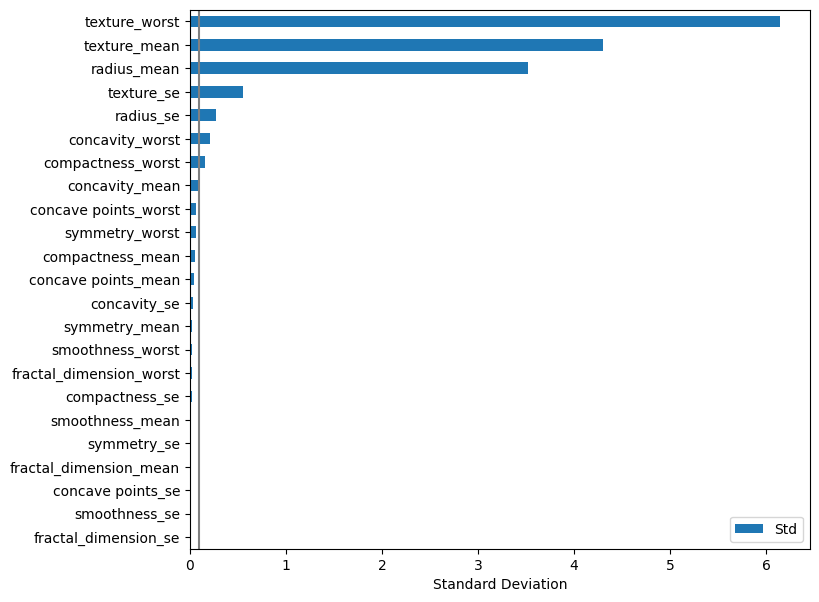

In [14]:
std_scores = pd.DataFrame(tfeatures.std())
std_scores.columns = ['Std']  # name output columns
std_scores.sort_values(by='Std', inplace=True)

std_scores.plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot
plt.axvline(x=0.1, color='.5') # add the reference line y = 0
plt.xlabel('Standard Deviation');

If we include only features with a variance greater that 0.1, this reduces our dataset to 7 features. The recall reduces by another 2%, though the precision and accuracy both improve.

In [15]:
features_highvar = tfeatures.loc[:, tfeatures.std() > 0.1]

print(features_highvar.shape)
print('\n')
print('Variance threshold')
logreg = LogisticRegression(penalty='none')
accuracy, precision, recall = model_accuracy(logreg, features_highvar, labels);

(569, 7)


Variance threshold
Metrics for LogisticRegression(penalty='none')
Accuracy  0.958
Precision  0.944
Recall  0.944




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


## SelectKBest

sklearn provides a number of functions which allow feature selection based on statistical tests comparing the feature set and the data labels. We will just consider `SelectKBest` here, which chooses the features with the highest statistical scores. To investigate other methods, see the sklearn documentation. The two common tests for classification problems are the chi2 (chi squared) test and the f_classif (ANOVA F-value) test. The f_classif is the default test for classification problems. For regression problems you would use f_regression, which calculates the correlation between features and labels.

`SelectKBest` works the same as other sklearn models where you instantiate the model, then fit the data to the model and then extract the information. In this case we just want the scores, so we don't specify how many features to extract. We can then extract the scores and display then based on their chi2 ranking.

<Axes: ylabel='Feature_Name'>

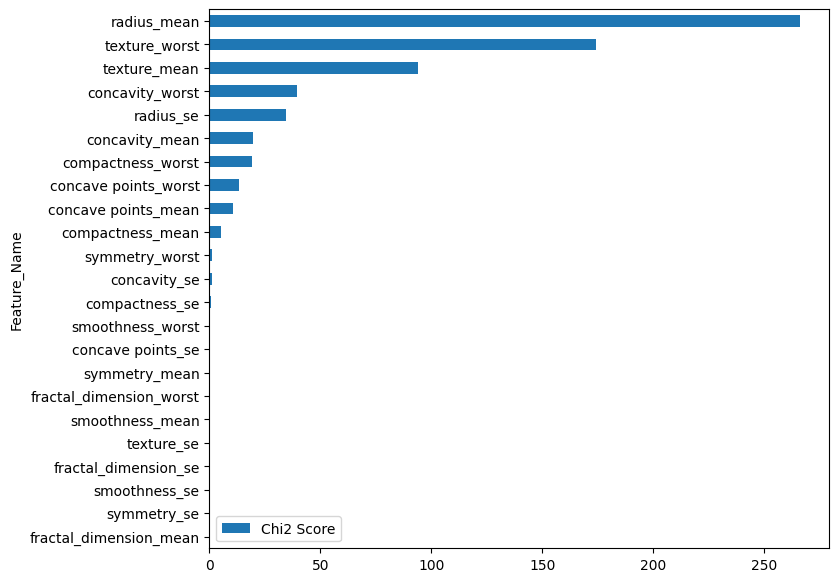

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

features_new = SelectKBest(chi2).fit(tfeatures, labels)
df_scores = pd.DataFrame(features_new.scores_)
df_columns = pd.DataFrame(tfeatures.columns)
# concatenate dataframes
chi2_scores = pd.concat([df_columns, df_scores],axis=1)
chi2_scores.columns = ['Feature_Name','Chi2 Score']  # name output columns
chi2_scores.set_index('Feature_Name', inplace=True)

chi2_scores.sort_values(by='Chi2 Score').plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot

To extract the k best features we then specify the number of features and fit and transform the data. We can then fit a logistic regression model to this transformed data. As can seen for this dataset the metrics all are very high, which suggests that the model is accurate and robust.

In [17]:
features_chi2 = SelectKBest(chi2, k=4).fit_transform(tfeatures, labels)

print('Chi2 test for SelectKBest with 4 features')
logreg = LogisticRegression(penalty='none')
accuracy, precision, recall = model_accuracy(logreg, features_chi2, labels)


Chi2 test for SelectKBest with 4 features
Metrics for LogisticRegression(penalty='none')
Accuracy  0.972
Precision  0.963
Recall  0.963




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


We can repeat the process using the ANOVA F-value test. In this case the distribution of scores is not quite as strong as for the chi2 test, and the accuracy metrics all decrease.

<Axes: ylabel='Feature_Name'>

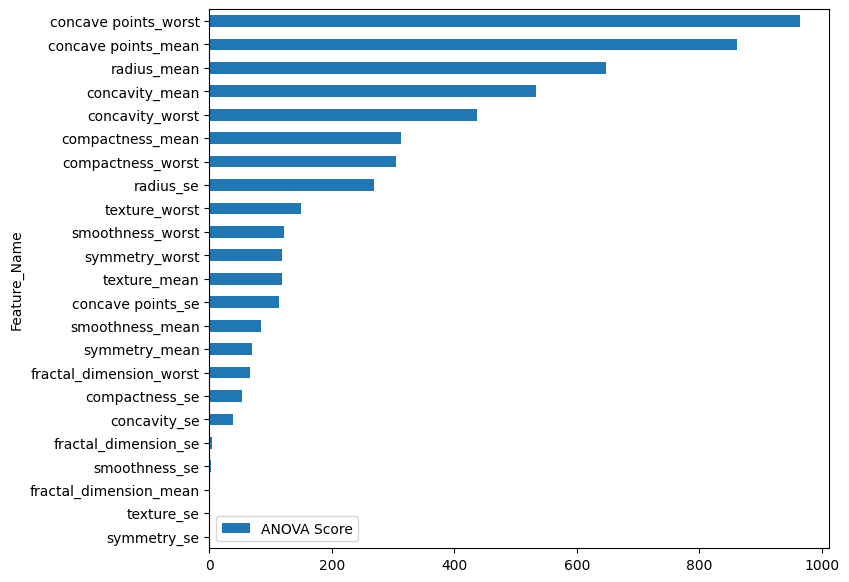

In [18]:
features_new = SelectKBest().fit(tfeatures, labels)
df_scores = pd.DataFrame(features_new.scores_)
df_columns = pd.DataFrame(tfeatures.columns)
# concatenate dataframes
anova_scores = pd.concat([df_columns, df_scores],axis=1)
anova_scores.columns = ['Feature_Name','ANOVA Score']  # name output columns

anova_scores.set_index('Feature_Name', inplace=True)
anova_scores.sort_values(by='ANOVA Score').plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot

In [19]:
features_anova = SelectKBest(k=4).fit_transform(tfeatures, labels)

print('ANOVA F test for SelectKBest with 4 features')
logreg = LogisticRegression(penalty='none')
accuracy, precision, recall = model_accuracy(logreg, features_anova, labels)


ANOVA F test for SelectKBest with 4 features
Metrics for LogisticRegression(penalty='none')
Accuracy  0.951
Precision  0.927
Recall  0.944




/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


As a comparison we can compare the scores for the three tests we have so far undertaken. Generally as one increases the other also increase, but there are some anomalies for the three different tests.

In this case, since each test is simple and quick, the best approach is to try each method and use the method that gives the best balance between bias and variance for your particular dataset.

In [20]:
scores = pd.concat([std_scores, chi2_scores, anova_scores], axis=1)
scores.columns = ['Std', 'Chi2', 'Anova']
scores.sort_values(by='Std')

,Std,Chi2,Anova
fractal_dimension_se,0.002646,0.006371,3.468275
smoothness_se,0.003003,0.003266,2.557968
concave points_se,0.006170,0.305232,113.262760
fractal_dimension_mean,0.007060,0.000074,0.093459
symmetry_se,0.008266,0.000080,0.024117
smoothness_mean,0.014064,0.149899,83.651123
compactness_se,0.017908,0.613785,53.247339
fractal_dimension_worst,0.018061,0.231522,66.443961
smoothness_worst,0.022832,0.397366,122.472880
symmetry_mean,0.027414,0.257380,69.527444


## SelectFromModel

The sklearn function `SelectFromModel` is our first example of a wrapper routine. This takes the output of a model and uses attributes of the model to rank the features and then extract features based on some threshold. The simplest way to understand this for Decision Tree type models which output a feature importance for each feature. This can then be used to rank the features, such that those with the highest importance are retained. The default threshold is to keep features with feature importance greater than the mean value.

`SelectFromModel` can also use the coefficients of a model such a linear or logistic regression or SVM to rank the features.

We will use `RandomForestClassifier` to illustrate the use of `SelectFromModel`, hence we first need to create a baseline for the accuracy metrics. Again, this baseline does not use optimization of parameters or cross-validation, but is rather just for reference.

In [21]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
accuracy, precision, recall = model_accuracy(rfc, tfeatures, labels)


Metrics for RandomForestClassifier()
Accuracy  0.951
Precision  0.943
Recall  0.926




To use this model we need to specify an estimator, which is in this case `RandomForestClassifier`, and a threshold for choosing features. For this classifier the feature importance will be used to select features, whereas for `LogisticRegression` the model coefficients would be used. The default for the threshold is the mean of the feature importance. This could be the median or a fraction of the mean, by specifying, for example, `threshold="0.5*mean"`. We then fit the model to the features and labels. For comparison with later routines we display the time taken.

In [22]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=RandomForestClassifier(), threshold="mean")
%timeit selector.fit(tfeatures, labels)

283 ms ± 58.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The scores for each feature then can be extracted using the object `estimator_.feature_importances_`, and the critical value for the scores can be extracted using the object `threshold_`. Then we can view the ranking of the features. Using the mean value gives that six features are selected.

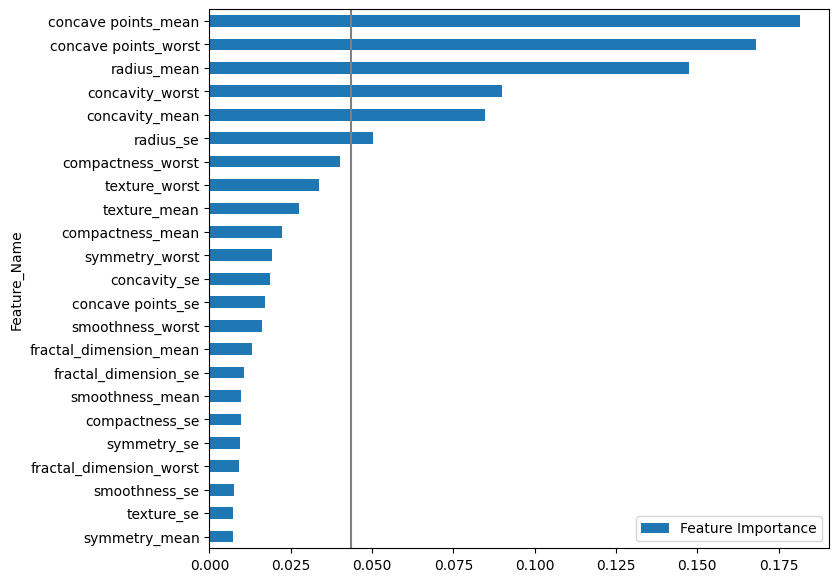

In [23]:
df_scores = pd.DataFrame(selector.estimator_.feature_importances_)
msfm = selector.threshold_
df_columns = pd.DataFrame(tfeatures.columns)
# concatenate dataframes
sfm_scores = pd.concat([df_columns, df_scores],axis=1)
sfm_scores.columns = ['Feature_Name','Feature Importance']  # name output columns
sfm_scores.set_index('Feature_Name', inplace=True)

sfm_scores.sort_values(by='Feature Importance').plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot
plt.axvline(x=msfm, color='.5') # add the reference line y = 0

To view the features that are selected we can retrieve the output of the method `get_support()`. This returns a binary array which is True if the feature is selected and otherwise False. For example, this can then be used to display the selected features.

In [24]:
tfeatures.columns[selector.get_support()]

Index(['radius_mean', 'concavity_mean', 'concave points_mean', 'radius_se',
       'concavity_worst', 'concave points_worst'],
      dtype='object')

Then we can create the reduced set of features using the `transform()` method. With this reduced dataset the accuracy and precision are slightly reduced, but the recall remains the same as the reference.

In [25]:
Xt = selector.transform(tfeatures)

rfc = RandomForestClassifier()
accuracy, precision, recall = model_accuracy(rfc, Xt, labels)


Metrics for RandomForestClassifier()
Accuracy  0.944
Precision  0.926
Recall  0.926




## Recursive Feature Elimination

The function `RFE` (Recursive Feature Elimination) again uses the scores of an estimator, but recursively eliminates features until the required number of features are obtained. For example, on the first step the model is fitted and the feature which contributes the least as measured by the estimator scores is eliminated. The process is then repeated. At each step one fitting of the model occurs, but as the number of features is reduced, subsequent steps will take less time.

`RFECV` implements this with cross-validation.

The model is set-up in the same way as `SelectFromModel`. The two main parameters to specify are `n_features_to_select` and `step`, which respectively corresponds to the final number of features selected and the number of features eliminated on each step. Due to the number of iterations, this takes significantly longer to run compared to `SelectFromModel`.

In [26]:
from sklearn.feature_selection import RFE

estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=5, step=1)
%timeit selector.fit(tfeatures, labels)

8.72 s ± 4.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


The relevant output of this model is the model is the ranking (`ranking_`), which details at which step that feature was eliminated. All features that are selected have a ranking of 1, the feature eliminated on the final step has a ranking of 2, and as the ranking increases that indicates the feature was eliminated on an earlier step.

<Axes: ylabel='Feature_Name'>

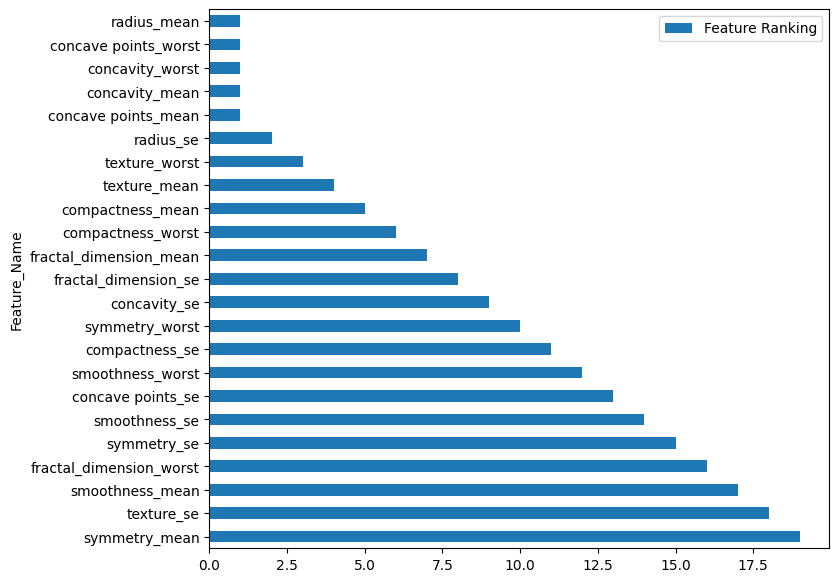

In [27]:
df_scores = pd.DataFrame(selector.ranking_)
df_columns = pd.DataFrame(tfeatures.columns)
# concatenate dataframes
rfe_scores = pd.concat([df_columns, df_scores],axis=1)
rfe_scores.columns = ['Feature_Name','Feature Ranking']  # name output columns
rfe_scores.set_index('Feature_Name', inplace=True)

rfe_scores.sort_values(by='Feature Ranking', ascending=False).plot(kind='barh', figsize=(8, 7)) # plot these as a bar plot

Again the selected features can be displayed using `get_support()`.

In [28]:
tfeatures.columns[selector.get_support()]

Index(['radius_mean', 'concavity_mean', 'concave points_mean',
       'concavity_worst', 'concave points_worst'],
      dtype='object')

For this selection all the metrics for the model are reduced in comparison with the reference run.

In [29]:
Xt = selector.transform(tfeatures)

rfc = RandomForestClassifier()
accuracy, precision, recall = model_accuracy(rfc, Xt, labels)

Metrics for RandomForestClassifier()
Accuracy  0.937
Precision  0.925
Recall  0.907




## Sequential Feature Selector

The final method considered here is `SequentialFeatureSelector`, which is new in Version 0.24 of sklearn. This has the advantages that it chooses features based on an accuracy measurement and can use cross-validation. The main disadvantage is that it is costly to run.

`SequentialFeatureSelector` can be run in forward or backward mode. In forward mode at the first iteration the feature is chosen which maximizes the particular accuracy measurement. Then on the next iteration one feature is added which again maximizes the metric. This continues until the chosen number of features is reached. In backward mode the first iteration includes all features and features are eliminated at each step. By default 5-fold cross-validation is used.

The setup is the same as previous models, except for the keywords `direction`, `scoring` and `cv`. `direction` controls whether forward or backward mode is used, with forward being the default. `scoring` controls the metric to be used. For example, we could use accuracy, precision or recall for classification, and r2_score for regression.

Due to the large number of models that need to be fitted, the runtime is significantly longer than for `SelectFromModel` and `RFE`.

In [30]:
from sklearn.feature_selection import SequentialFeatureSelector

estimator = RandomForestClassifier()
selector = SequentialFeatureSelector(estimator, n_features_to_select=5, scoring='recall')
%timeit selector.fit(tfeatures, labels)

1min 54s ± 7.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Again, we can view the chose features using `get_support()`.

In [31]:
tfeatures.columns[selector.get_support()]

Index(['radius_mean', 'texture_mean', 'smoothness_worst', 'concavity_worst',
       'concave points_worst'],
      dtype='object')

Now although the model takes longer to run, the accuracy measurements are all at least as good as for the reference run.

In [32]:
Xt = selector.transform(tfeatures)

rfc = RandomForestClassifier()
accuracy, precision, recall = model_accuracy(rfc, Xt, labels)

Metrics for RandomForestClassifier()
Accuracy  0.944
Precision  0.911
Recall  0.944




## Exercises

For the exercises we will use the [Boston Housing dataset](https://www.kaggle.com/c/boston-housing), which is part of the sklearn datasets. The function below fits an sklearn regression models, such as linear regresssion, SVR or Random Forest Regression.

In [33]:
def reg_model_accuracy(model, features, labels, randomnumb=42):
    '''Convenience function to fit an sklearn regression model and calculate the r2 score'''
    import numpy as np
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import r2_score # import the score functions
    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state=randomnumb)
    pipe = make_pipeline(StandardScaler(), model)
    pipe.fit(X_train, y_train)  # apply scaling on training data
    y_pred= pipe.predict(X_test) # calculate the predicted values of the model for the test features

    rsq = np.round(r2_score(y_test, y_pred),3)

    return rsq

Load and display the dataset.

In [34]:
Boston = pd.read_csv('/content/drive/MyDrive/csv files/Boston_housing.csv')
BostonFeatures = Boston.drop(columns=['medv'])
BostonLabels = Boston['medv']
Boston

,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
3,5,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
4,7,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311,15.2,395.60,12.43,22.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328,500,0.17783,0.0,9.69,0,0.585,5.569,73.5,2.3999,6,391,19.2,395.77,15.10,17.5
329,502,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
330,503,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
331,504,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9


### Exercise 1 (2 marks)

Create a base regression model using the RandomForestRegressor.

In [35]:
from sklearn.ensemble import RandomForestRegressor

rfg = RandomForestRegressor()


### Exercise 2 (4 marks)

Use SelectKBest using f_regression to select the best 5 features. Print out these features and determine the accuracy of the RandomForestRegressor with this reduced dataset.

In [69]:
features = SelectKBest(score_func=f_regression, k=5)
features_reduced = features.fit_transform(BostonFeatures, BostonLabels)
selected_feature_indices = features.get_support(indices=True)

BostonFeatures.columns[features.get_support()]

Index(['indus', 'rm', 'tax', 'ptratio', 'lstat'], dtype='object')

In [75]:
x_feature = Boston[['indus', 'rm', 'tax', 'ptratio', 'lstat']]

accuracy = rfg.score(x_feature,BostonLabels)
print(accuracy)

0.0025613939154588428


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


### Exercise 3 (4 marks)

Repeat Exercise 2, but use RFE (Recursive Feature Elimination).

In [67]:
estimator = RandomForestRegressor()
selector = RFE(estimator, n_features_to_select=5, step=1)
%timeit selector.fit(BostonFeatures, BostonLabels)

BostonFeatures.columns[selector.get_support()]

3.42 s ± 719 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Index(['ID', 'crim', 'rm', 'dis', 'lstat'], dtype='object')

In [76]:
x_feature = Boston[['ID', 'crim', 'rm', 'dis', 'lstat']]

rfg = RandomForestRegressor()
accuracy = rfg.score(x_feature,BostonLabels)
print(accuracy)

NotFittedError: ignored